**Modified by: Yohan Lee (Last update: Jun 14, 2023)**

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Gesture recognition tutorial
 * Sandeep Mistry - Arduino
 * Don Coleman - Chariot Solutions


https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

# Setup Python Environment

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
!apt-get -qq install xxd
!pip install pandas numpy matplotlib
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Prepare data

## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the fully connected neural network.

Update the `GESTURES` list with the gesture data you've collected in `.csv` format.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

filepath = '/content/'

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 47
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "fist_left",
    "fist_right",
    "fist_up",
    "fist_down",
    "fist_center",
    "palm_left",
    "palm_right",
    "palm_up",
    "palm_down",
    "palm_center"
]

SAMPLES_PER_GESTURE = 150
NUM_FEATURES = 8

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")

    output = ONE_HOT_ENCODED_GESTURES[gesture_index]

    df = pd.read_csv(filepath + gesture + ".csv")
    df = df.drop(columns=['timestamp'])
    df = df.dropna()
    df = df.reset_index(drop=True)

    # calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

    for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j
            # normalize the input data, between 0 to 1:
            # - acceleration is between: -4 to +4
            # - gyroscope is between: -2000 to +2000
            tensor += [
            df['eD'][index] / 500000,
            df['eU'][index] / 500000,
            (df['aX'][index] + 4) / 8,
            (df['aY'][index] + 4) / 8,
            (df['aZ'][index] + 4) / 8,
            (df['gX'][index] + 2000) / 4000,
            (df['gY'][index] + 2000) / 4000,
            (df['gZ'][index] + 2000) / 4000
            ]
        inputs.append(tensor)
        outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")
print(inputs.shape, outputs.shape)

TensorFlow version = 2.12.0

Processing index 0 for gesture 'fist_left'.
	There are 77 recordings of the fist_left gesture.
Processing index 1 for gesture 'fist_right'.
	There are 81 recordings of the fist_right gesture.
Processing index 2 for gesture 'fist_up'.
	There are 82 recordings of the fist_up gesture.
Processing index 3 for gesture 'fist_down'.
	There are 77 recordings of the fist_down gesture.
Processing index 4 for gesture 'fist_center'.
	There are 84 recordings of the fist_center gesture.
Processing index 5 for gesture 'palm_left'.
	There are 82 recordings of the palm_left gesture.
Processing index 6 for gesture 'palm_right'.
	There are 81 recordings of the palm_right gesture.
Processing index 7 for gesture 'palm_up'.
	There are 84 recordings of the palm_up gesture.
Processing index 8 for gesture 'palm_down'.
	There are 78 recordings of the palm_down gesture.
Processing index 9 for gesture 'palm_center'.
	There are 83 recordings of the palm_center gesture.
Data set parsing 

## Randomize and split the input and output pairs for training

Randomly split input and output pairs into sets of data: 60% for training, 20% for validation, and 20% for testing.

  - the training set is used to train the model
  - the validation set is used to measure how well the model is performing during training
  - the testing set is used to test the model after training

In [ ]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# reshape (for LSTM)
inputs = inputs.reshape((-1, SAMPLES_PER_GESTURE, NUM_FEATURES))
outputs = np.argmax(outputs, axis=1)

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [ ]:
print(inputs_train.shape, inputs_test.shape, inputs_validate.shape)
print(outputs_train.shape, outputs_test.shape, outputs_validate.shape)

(485, 150, 8) (161, 150, 8) (163, 150, 8)
(485,) (161,) (163,)


# Train Neural Network





## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# Set random seed again here. If not, TF does not make same outputs.
SEED = 47
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from tensorflow import keras

'''------ Begin: Model specification ------'''
### HERE IS THE SPECIFICATION OF YOUR MODEL ###
input_shape = inputs_train.shape[1:]

cnn_model_1 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=input_shape),
    keras.layers.Conv1D(filters=32, kernel_size=7, padding='same',
                        activation='relu',
                        kernel_initializer=keras.initializers.HeNormal(seed=SEED)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(rate=0.5),

    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=64, kernel_size=7, padding='same',
                        activation='relu',
                        kernel_initializer=keras.initializers.HeNormal(seed=SEED)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(rate=0.5),

    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=128, kernel_size=7, padding='same',
                        activation='relu',
                        kernel_initializer=keras.initializers.HeNormal(seed=SEED)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.Dropout(rate=0.5),

    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax',
                       kernel_initializer=keras.initializers.HeNormal(seed=SEED))
])

cnn_model_2 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=input_shape),
    keras.layers.Conv1D(
        filters=16, kernel_size=7, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.Dropout(
        rate=0.5
    ),

    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(
        filters=64, kernel_size=7, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.Dropout(
        rate=0.5
    ),

    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=10,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
])

cnn_model_3 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=input_shape),
    keras.layers.Conv1D(
        filters=16, kernel_size=7, padding = "same",
        activation = keras.activations.relu,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
    keras.layers.MaxPooling1D(
        pool_size=2
    ),
    keras.layers.Dropout(
        rate=0.5
    ),

    # keras.layers.BatchNormalization(),
    # keras.layers.Conv1D(
    #     filters=32, kernel_size=7, padding = "same",
    #     activation = keras.activations.relu,
    #     kernel_initializer=keras.initializers.HeNormal(seed=42),
    # ),
    # keras.layers.MaxPooling1D(
    #     pool_size=2
    # ),
    # keras.layers.Dropout(
    #     rate=0.5
    # ),

    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=10,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.HeNormal(seed=42),
    ),
])

lstm_model_1 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=input_shape),
    keras.layers.LSTM(
        units=64,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=SEED),
        return_sequences=True
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.LSTM(
        units=128,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=SEED),
        return_sequences=False
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    keras.layers.Dense(
        units = NUM_GESTURES,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=SEED)
    )
])

lstm_model_2 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=input_shape),
    keras.layers.LSTM(
        units=32,
        activation=keras.activations.tanh,
        kernel_initializer=keras.initializers.GlorotNormal(seed=SEED),
        return_sequences=False
    ),
    keras.layers.Dropout(
        rate=0.5
    ),
    # keras.layers.LSTM(
    #     units=64,
    #     activation=keras.activations.tanh,
    #     kernel_initializer=keras.initializers.GlorotNormal(seed=SEED),
    #     return_sequences=False
    # ),
    # keras.layers.Dropout(
    #     rate=0.5
    # ),
    keras.layers.Dense(
        units=NUM_GESTURES,
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=SEED)
    )
])


conv_lstm_model_1 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=(150, 8)),
    keras.layers.Conv1D(32, 7, activation='relu', padding='same',
                        kernel_initializer=keras.initializers.HeNormal(seed=42)),
    keras.layers.MaxPooling1D(2),
    keras.layers.Dropout(0.5),

    keras.layers.Conv1D(64, 7, activation='relu', padding='same',
                        kernel_initializer=keras.initializers.HeNormal(seed=42)),
    keras.layers.MaxPooling1D(2),
    keras.layers.Dropout(0.5),

    keras.layers.BatchNormalization(),
    keras.layers.LSTM(64, return_sequences=False,
                      kernel_initializer=keras.initializers.HeNormal(seed=42)),
    keras.layers.Dropout(0.5),

    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax',
                       kernel_initializer=keras.initializers.HeNormal(seed=42))
])

mlp_model_1 = keras.models.Sequential([
    keras.layers.BatchNormalization(input_shape=(150, 8)),
    keras.layers.Flatten(),

    keras.layers.Dense(64, activation='relu',
                       kernel_initializer=keras.initializers.HeNormal(seed=42)),
    keras.layers.Dropout(0.5),

    # keras.layers.Dense(128, activation='relu',
    #                    kernel_initializer=keras.initializers.HeNormal(seed=42)),
    # keras.layers.Dropout(0.5),

    keras.layers.Dense(32, activation='relu',
                       kernel_initializer=keras.initializers.HeNormal(seed=42)),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(10, activation='softmax',
                       kernel_initializer=keras.initializers.HeNormal(seed=42)),
])

model = cnn_model_3
# model = lstm_model_2
# model = conv_lstm_model_1
# model = mlp_model_1
print(model.summary())

'''------ End: Model specification ------'''

'''------ Begin: Model compiling ------'''
model.compile(
    # We will use a logistic loss as the loss function.
    # But, you can use any optimizers, metrics, or other options here.
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
            'mae',
    ]
    ### HERE IS THE SPECIFICATION OF OPTIMIZER, METRICS, etc... ###
)
'''------ End: Model compiling ------'''

'''------ Begin: Model fitting ------'''
history = model.fit(
    x=inputs_train,
    y=outputs_train,
    ### HERE IS THE SPECIFICATION OF TRAINING OPTIONS ###
    batch_size=32,
    epochs=200,
    validation_data=(inputs_validate, outputs_validate),
    callbacks=[
        keras.callbacks.TensorBoard(log_dir=f'./logs/0', histogram_freq=1),
        keras.callbacks.EarlyStopping(
            monitor='val_sparse_categorical_accuracy', min_delta=0.0005, patience=30, verbose=0, mode='auto',
            baseline=None, restore_best_weights=True
        )
    ]
)
'''------ End: Model fitting ------'''

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_22 (Bat  (None, 150, 8)           32        
 chNormalization)                                                
                                                                 
 conv1d_13 (Conv1D)          (None, 150, 16)           912       
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 75, 16)           0         
 g1D)                                                            
                                                                 
 dropout_19 (Dropout)        (None, 75, 16)            0         
                                                                 
 batch_normalization_23 (Bat  (None, 75, 16)           64        
 chNormalization)                                                
                                                      

'------ End: Model fitting ------'

## Verify

Graph the models performance vs validation.


### Graph the loss

Graph the loss to see when the model stops improving.

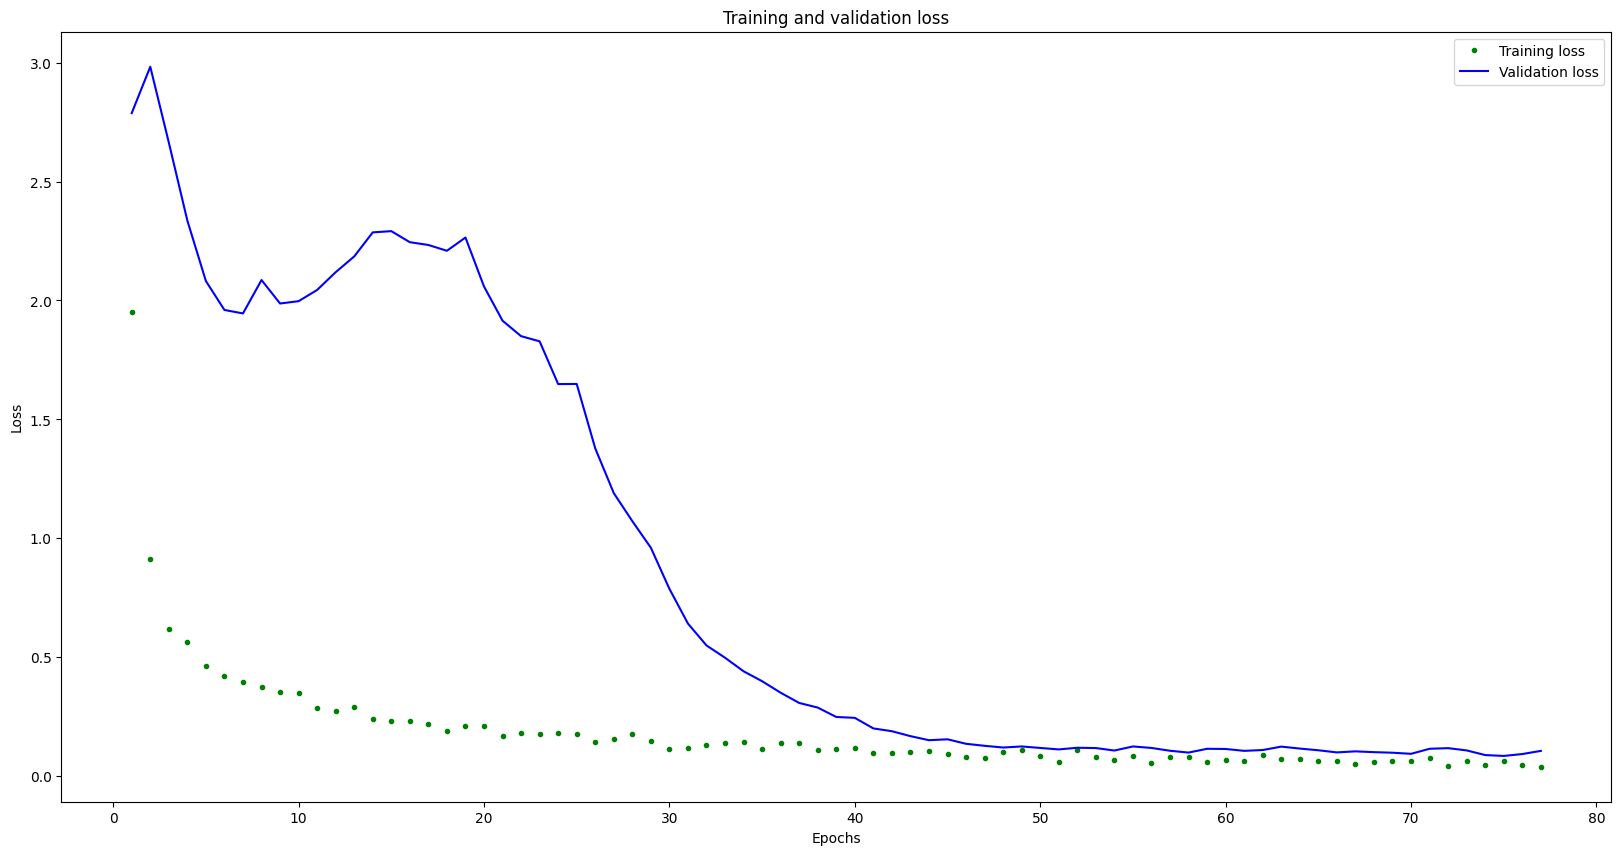

[20.0, 10.0]


In [ ]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

### Graph the loss again, skipping a bit of the start

We'll graph the same data as the previous code cell, but start at index 100 so we can further zoom in once the model starts to converge.

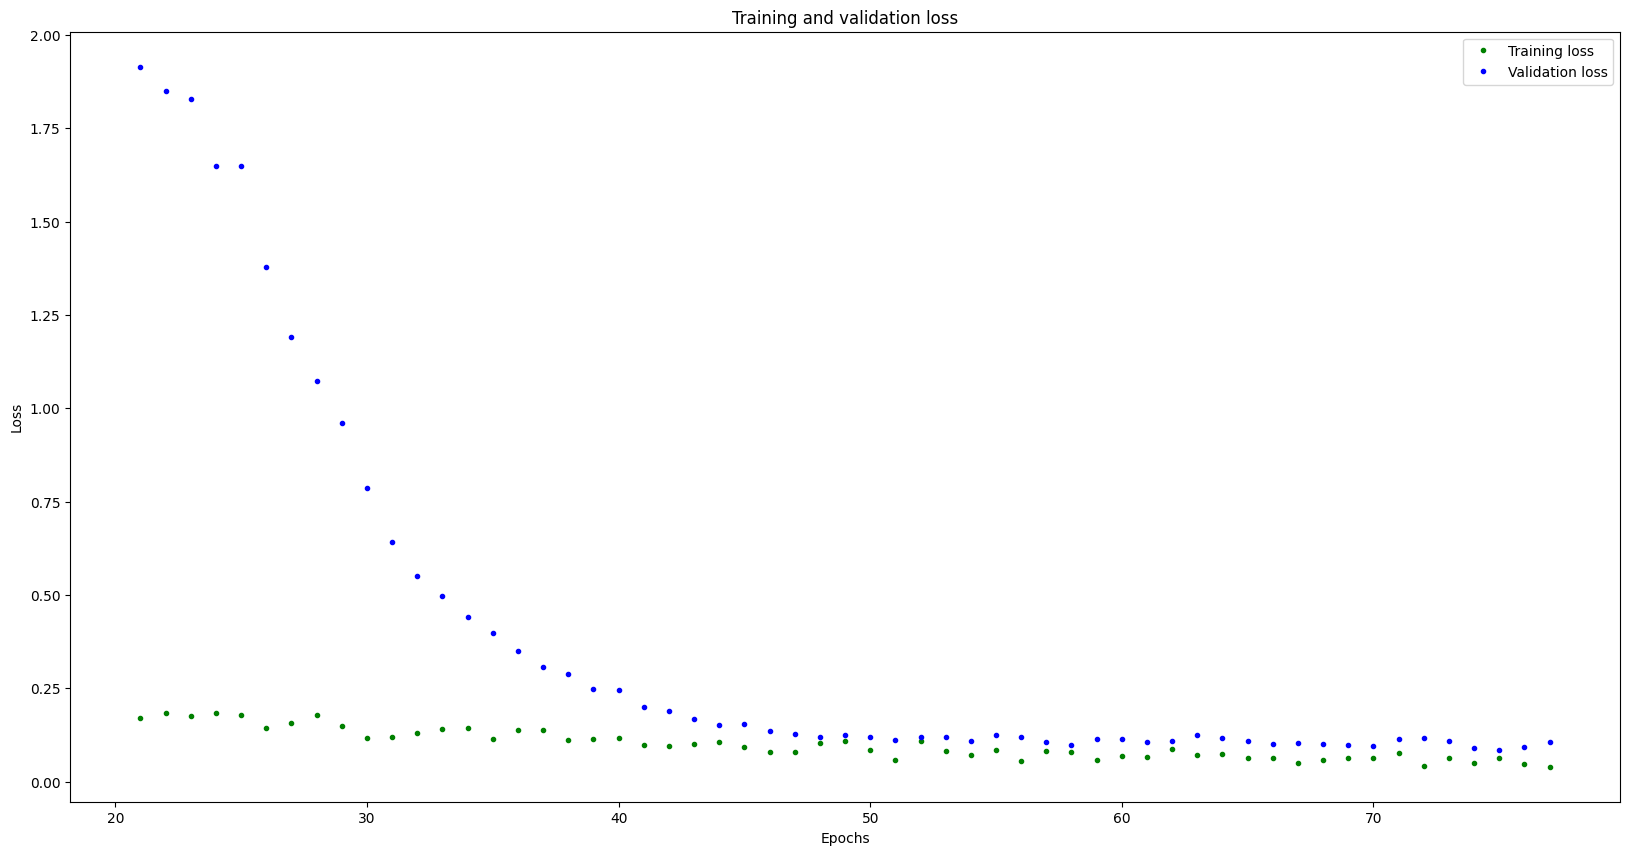

In [ ]:
# graph the loss again skipping a bit of the start
SKIP = 20
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Graph the mean absolute error

[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) is another metric to judge the performance of the model.



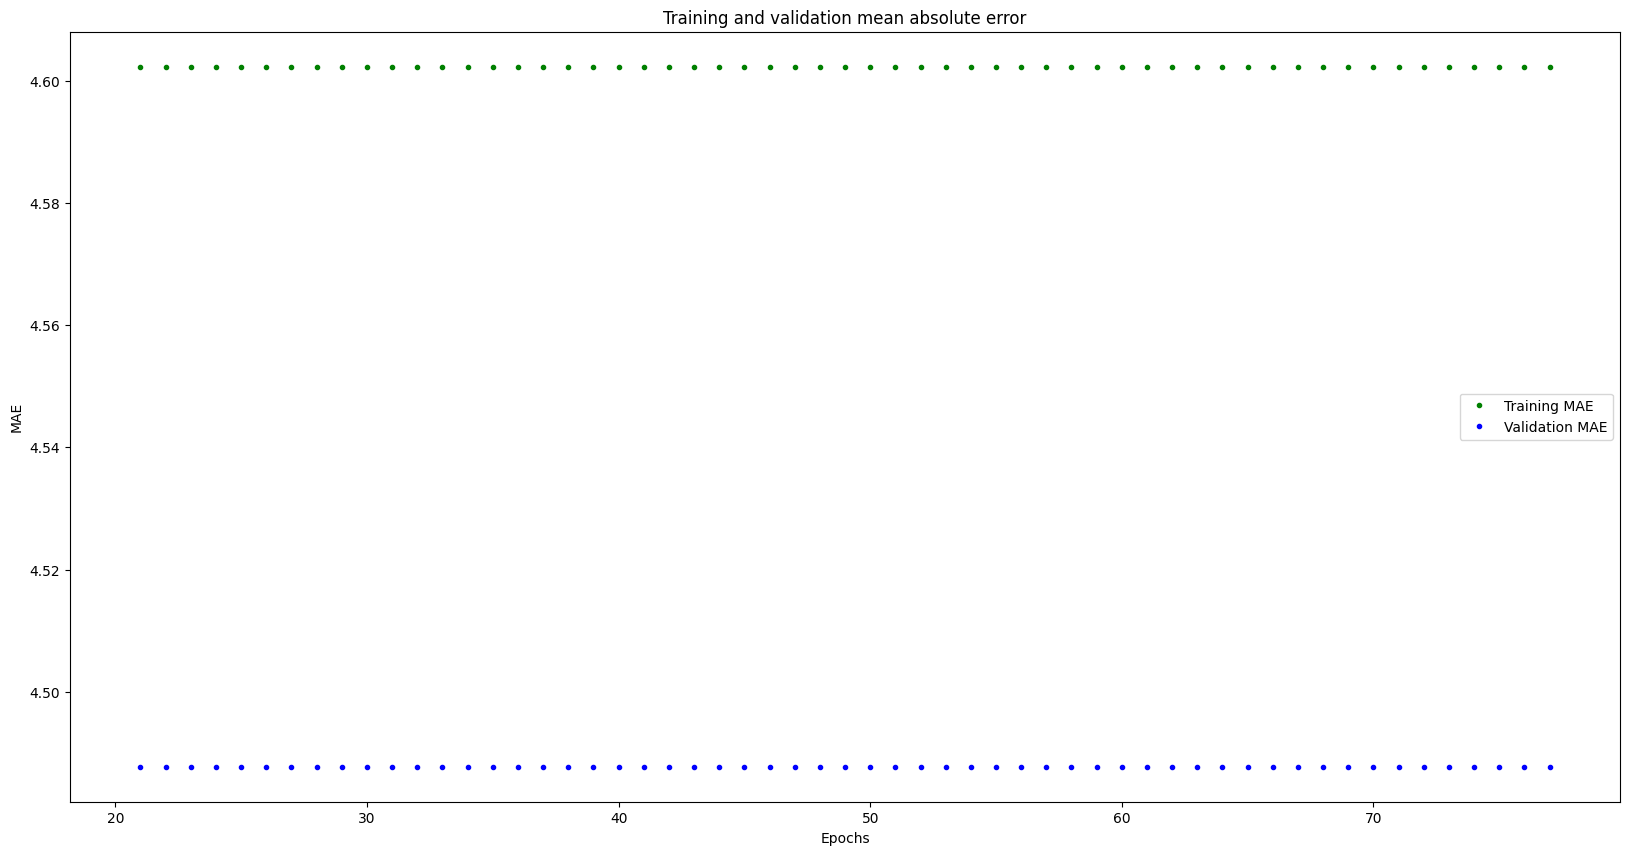

In [ ]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


### Run with test data
Put our test data into the model and plot the predictions


In [ ]:
from sklearn.metrics import accuracy_score

predictions = np.argmax(model.predict(inputs_test), axis=1)
acc = accuracy_score(outputs_test, predictions)
print(predictions)
print(outputs_test)

print(f'Accuracy: {acc * 100:.2f} %.')

6/6 [==============================] - 0s 4ms/step
[4 6 6 3 0 2 9 1 4 9 8 6 4 2 4 6 3 7 9 1 6 5 9 1 7 7 5 5 5 9 4 6 4 6 6 0 9
 9 7 5 3 3 2 0 4 2 9 2 8 9 0 7 7 0 3 9 8 1 3 4 7 1 2 7 2 4 1 9 4 4 2 3 0 1
 2 5 3 9 2 3 7 0 9 2 0 9 4 0 0 2 1 0 6 6 8 4 2 1 4 7 0 7 0 8 0 1 5 1 6 8 9
 8 8 4 3 1 0 0 2 9 3 3 4 3 0 1 1 1 3 2 0 9 5 8 7 2 4 7 7 7 2 9 0 5 7 2 2 5
 3 7 6 7 8 2 4 6 0 1 8 0 3]
[4 6 6 3 0 2 9 1 4 9 8 6 4 2 4 6 3 7 9 1 6 5 0 6 7 7 5 5 5 9 4 6 4 6 6 0 9
 9 2 5 3 3 2 0 4 2 9 2 8 9 0 7 7 0 3 9 8 1 3 4 7 1 2 7 7 4 1 5 4 4 2 3 0 1
 2 5 3 0 2 3 7 0 9 1 0 9 4 0 0 2 1 0 0 0 8 4 2 1 4 7 0 7 0 8 0 1 5 1 6 8 9
 8 8 4 3 1 0 0 2 9 3 3 4 3 0 1 1 1 3 2 0 9 5 8 7 2 4 7 7 7 2 9 0 5 7 2 2 5
 3 7 6 7 8 2 3 6 0 1 8 0 3]
Accuracy: 93.79 %.


In [ ]:
# Save tensorflow model
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)

model.save(MODELS_DIR + 'model.h5')

# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

**Run from this cell if you have model.h**

## Load model and parse data (again)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

# load tensorflow model
MODELS_DIR = 'models/'
model = tf.keras.models.load_model(MODELS_DIR + 'model.h5')

parse_data_again = False

In [ ]:
if parse_data_again:
    filepath = '/content/'

    print(f"TensorFlow version = {tf.__version__}\n")

    # Set a fixed random seed value, for reproducibility, this will allow us to get
    # the same random numbers each time the notebook is run
    SEED = 47
    np.random.seed(SEED)
    tf.random.set_seed(SEED)

    # the list of gestures that data is available for
    GESTURES = [
        "fist_left",
        "fist_right",
        "fist_up",
        "fist_down",
        "fist_center",
        "palm_left",
        "palm_right",
        "palm_up",
        "palm_down",
        "palm_center"
    ]

    SAMPLES_PER_GESTURE = 150
    NUM_FEATURES = 8

    NUM_GESTURES = len(GESTURES)

    # create a one-hot encoded matrix that is used in the output
    ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

    inputs = []
    outputs = []

    # read each csv file and push an input and output
    for gesture_index in range(NUM_GESTURES):
        gesture = GESTURES[gesture_index]
        print(f"Processing index {gesture_index} for gesture '{gesture}'.")

        output = ONE_HOT_ENCODED_GESTURES[gesture_index]

        df = pd.read_csv(filepath + gesture + ".csv")
        df = df.drop(columns=['timestamp'])
        df = df.dropna()
        df = df.reset_index(drop=True)

        # calculate the number of gesture recordings in the file
        num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

        print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

        for i in range(num_recordings):
            tensor = []
            for j in range(SAMPLES_PER_GESTURE):
                index = i * SAMPLES_PER_GESTURE + j
                # normalize the input data, between 0 to 1:
                # - acceleration is between: -4 to +4
                # - gyroscope is between: -2000 to +2000
                tensor += [
                    df['eD'][index] / 500000,
                    df['eU'][index] / 500000,
                    (df['aX'][index] + 4) / 8,
                    (df['aY'][index] + 4) / 8,
                    (df['aZ'][index] + 4) / 8,
                    (df['gX'][index] + 2000) / 4000,
                    (df['gY'][index] + 2000) / 4000,
                    (df['gZ'][index] + 2000) / 4000
                ]
            inputs.append(tensor)
            outputs.append(output)

    # convert the list to numpy array
    inputs = np.array(inputs)
    outputs = np.array(outputs)

    print("Data set parsing and preparation complete.")
    print(inputs.shape, outputs.shape)

    # Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
    # https://stackoverflow.com/a/37710486/2020087
    num_inputs = len(inputs)
    randomize = np.arange(num_inputs)
    np.random.shuffle(randomize)

    # Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
    inputs = inputs[randomize]
    outputs = outputs[randomize]

    # reshape (for LSTM)
    inputs = inputs.reshape((-1, SAMPLES_PER_GESTURE, NUM_FEATURES))
    outputs = np.argmax(outputs, axis=1)

    # Split the recordings (group of samples) into three sets: training, testing and validation
    TRAIN_SPLIT = int(0.6 * num_inputs)
    TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

    inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
    outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

    print("Data set randomization and splitting complete.")

## Convert model to TF Lite format

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,  # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS  # enable TensorFlow ops.
]
converter._experimental_lower_tensor_list_ops = False
tflite_model_no_quant = converter.convert()

# Save the model to disk
open(MODELS_DIR + "gesture_model_no_quant.tflite", "wb").write(tflite_model_no_quant)

import os
model_no_quant_size = os.path.getsize(MODELS_DIR + "gesture_model_no_quant.tflite")
print("Model w/o quant is %d bytes" % model_no_quant_size)


Model w/o quant is 56816 bytes


In [ ]:
# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  # put your dataset format
  for i in range(inputs_train.shape[0]):
    yield [inputs_train[i].reshape(1, inputs_train.shape[1], inputs_train.shape[2]).astype(np.float32)]

# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# The most important point is you need to specify "supported_ops"
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# in this case, the arduino input will be  model_input->data.f[i]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
tflite_model_quant = converter.convert()

# Save the model to disk
open(MODELS_DIR + "gesture_model_quant.tflite", "wb").write(tflite_model_quant)

model_quant_size = os.path.getsize(MODELS_DIR + "gesture_model_quant.tflite")
print("Model w/ quant is %d bytes" % model_quant_size)

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


Model w/ quant is 19432 bytes


## Encode the Model in an Arduino Header File

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
# without quant
!echo "const unsigned char model[] = {" > /content/models/model_no_quant.h
!cat models/gesture_model_no_quant.tflite | xxd -i      >> /content/models/model_no_quant.h
!echo "};"                              >> /content/models/model_no_quant.h

import os
model_no_quant_h_size = os.path.getsize(MODELS_DIR + "model_no_quant.h")
print(f"Header file, model_no_quant.h, is {model_no_quant_h_size / 1024 :.3f} KB.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model_no_quant.h, is 342.188 KB.

Open the side panel (refresh if needed). Double click model.h to download the file.


In [ ]:
# with quantization
!echo "const unsigned char model[] = {" > /content/models/model_quant.h
!cat models/gesture_model_quant.tflite | xxd -i      >> /content/models/model_quant.h
!echo "};"                              >> /content/models/model_quant.h

import os
model_quant_h_size = os.path.getsize(MODELS_DIR + "model_quant.h")
print(f"Header file, model_quant.h, is {model_quant_h_size / 1024 :.3f} KB.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model_quant.h, is 117.057 KB.

Open the side panel (refresh if needed). Double click model.h to download the file.
